## Import Dependencies 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import nltk

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [3]:
import time
import random
import sys

from typing import Optional, List
from collections import Counter

import numpy as np

from tqdm import tqdm

from src.enums import Fields
from src.models.Document import Document
from src.types import DocID
from src.utils.read_document import read_documents_json
from src.utils.extract_train_feature_matrix import extract_train_feature_matrix
from src.utils.extract_val_feature_matrix import extract_val_feature_matrix
from src.models.TextPreprocessor import (
    PersianTextPreprocessor,
    EnglishTextPreprocessor,
    TextPreprocessor,
)
from src.ml.MLMetrics import MLMetrics
from src.models.Manager import Manager

seed = 42
random.seed(seed)
np.random.seed(seed)

## Prepare Data 

In [4]:
def prepare_data(text_preprocessor: Optional[TextPreprocessor] = None):
    if text_preprocessor is None:
        text_preprocessor = EnglishTextPreprocessor(lemmatize=True)
    train_documents = read_documents_json(
        "./MIR_Phase2/data/train.json", text_preprocessor
    )
    val_documents = read_documents_json(
        "./MIR_Phase2/data/validation.json", text_preprocessor
    )
    manager = Manager(
        train_documents, [Fields.BODY, Fields.TITLE], text_preprocessor
    )
    train_labels = np.array([doc.category - 1 for doc in train_documents])
    val_labels = np.array([doc.category - 1 for doc in val_documents])
    return train_documents, val_documents, manager, train_labels, val_labels

In [5]:
train_documents, val_documents, manager, train_labels, val_labels = (
    prepare_data()
)
fields = manager.fields
num_tokens = len(manager.corpus_index.index)
num_train_docs = len(manager.documents)
num_val_docs = len(val_documents)

100%|██████████| 24000/24000 [00:06<00:00, 3432.17it/s]


In [9]:
# train_matrix = extract_train_feature_matrix(manager)
# val_matrix = extract_val_feature_matrix(manager, val_documents)

## KNN 

### Get Ready! 

In [11]:
from src.ml.KNN import KNN
from src.enums import Measures

k_choices = [1, 3, 5]

In [9]:
def test_knn(
    manager: Manager,
    val_documents: List[Document],
    k_choices: List[int],
    measure: Measures = Measures.COSINE_SIMILARITY,
):
    knn = KNN(manager, val_documents, measure)
    knn.extract_feature_matrices()
    knn.calculate_measure()
    results = [np.array(knn.run(k)) - 1 for k in k_choices]
    for k, result in zip(k_choices, results):
        print(f"+++++ K: {k} +++++")
        cm = MLMetrics.compute_confusion_matrix(val_labels, result)
        MLMetrics.plot_confusion_matrix(
            cm,
            ["World", "Sports", "Business", "Sci/Tech"],
            ["World", "Sports", "Business", "Sci/Tech"],
            title=f"K: {k}",
            dpi=150,
        )
        MLMetrics.print_summary_metrics(cm)

### KNN with Cosine Similarity 

#### Results 

100%|██████████| 26952/26952 [00:14<00:00, 1905.03it/s]


+++++ K: 1 +++++


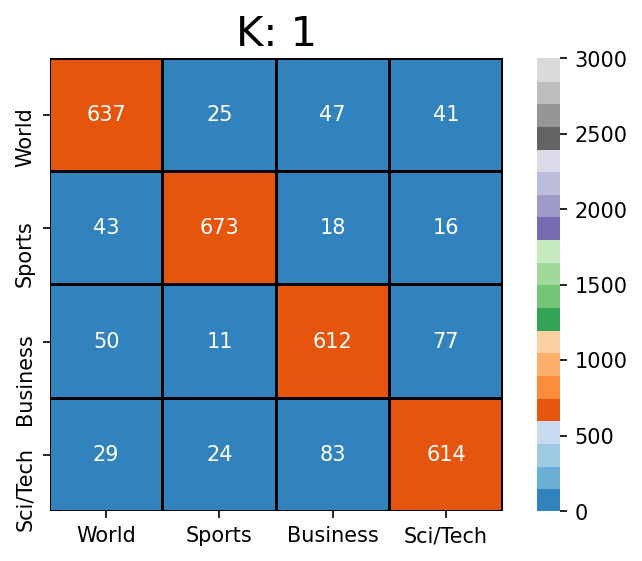

label precision recall
    1     0.839  0.849
    2     0.918  0.897
    3     0.805  0.816
    4     0.821  0.819
macro averaged precision: 0.845881392785794
macro averaged recall: 0.8453333333333333
accuracy: 0.8453333333333334
macro averaged recall f1: 0.8456072742567763
+++++ K: 3 +++++


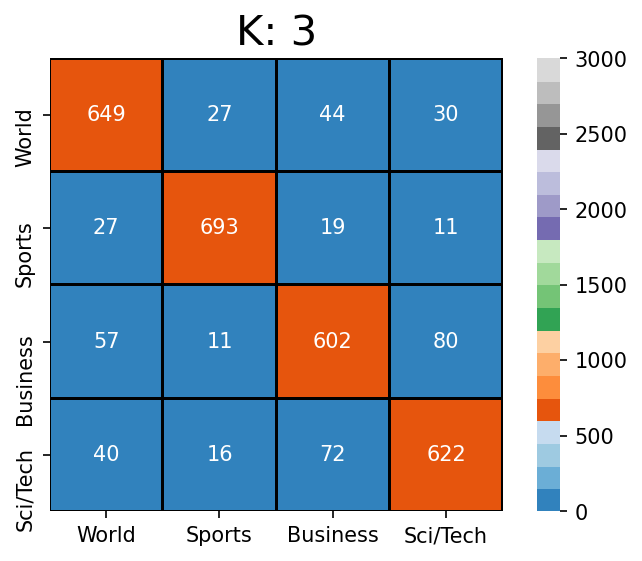

label precision recall
    1     0.840  0.865
    2     0.928  0.924
    3     0.817  0.803
    4     0.837  0.829
macro averaged precision: 0.8553171351174839
macro averaged recall: 0.8553333333333334
accuracy: 0.8553333333333333
macro averaged recall f1: 0.8553252341487178
+++++ K: 5 +++++


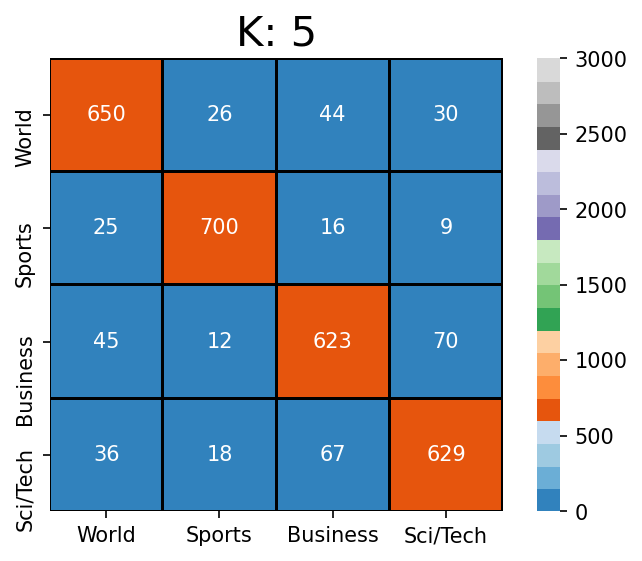

label precision recall
    1     0.860  0.867
    2     0.926  0.933
    3     0.831  0.831
    4     0.852  0.839
macro averaged precision: 0.8671711188540456
macro averaged recall: 0.8673333333333333
accuracy: 0.8673333333333333
macro averaged recall f1: 0.867252218508371


In [12]:
test_knn(manager, val_documents, k_choices, Measures.COSINE_SIMILARITY)

#### Conslusion 

Best setting with measure being cosine similarity is k = 5.

### KNN with Euclidean Distance

#### Results 

100%|██████████| 26952/26952 [00:13<00:00, 1998.15it/s]


+++++ K: 1 +++++


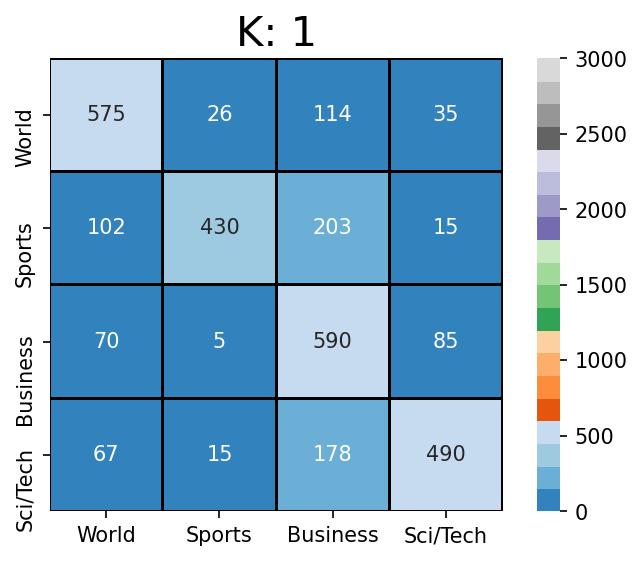

label precision recall
    1     0.706  0.767
    2     0.903  0.573
    3     0.544  0.787
    4     0.784  0.653
macro averaged precision: 0.7343820881923349
macro averaged recall: 0.6950000000000001
accuracy: 0.695
macro averaged recall f1: 0.7141485198532793
+++++ K: 3 +++++


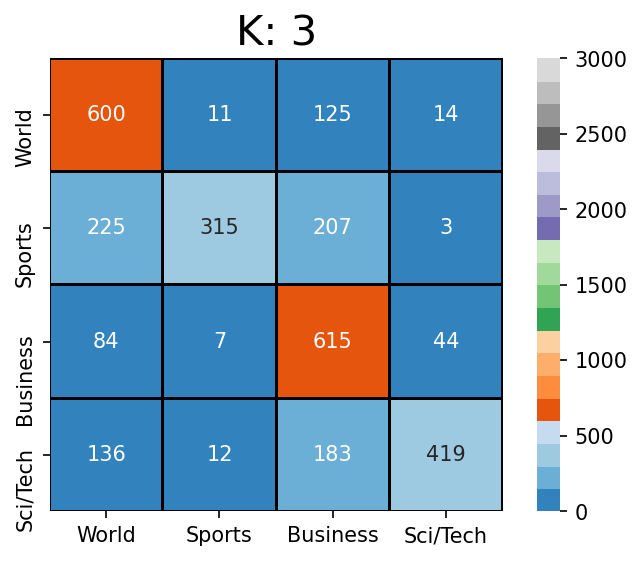

label precision recall
    1     0.574  0.800
    2     0.913  0.420
    3     0.544  0.820
    4     0.873  0.559
macro averaged precision: 0.7260926529909982
macro averaged recall: 0.6496666666666666
accuracy: 0.6496666666666666
macro averaged recall f1: 0.6857568570601402
+++++ K: 5 +++++


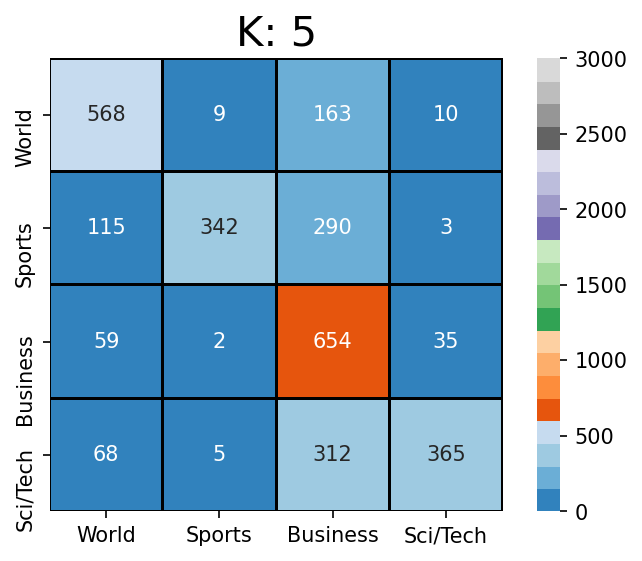

label precision recall
    1     0.701  0.757
    2     0.955  0.456
    3     0.461  0.872
    4     0.884  0.487
macro averaged precision: 0.7503017548601382
macro averaged recall: 0.643
accuracy: 0.643
macro averaged recall f1: 0.6925190852479726


In [13]:
test_knn(manager, val_documents, k_choices, Measures.EUCLIDEAN_DISTANCE)

#### Conclusion 

Best setting with measure being cosine similarity is k = 1.

## NaiveBayes

### Get Ready 

In [10]:
from src.ml.NaiveBayes import NaiveBayes

In [11]:
smoothing_options = [1, 5, 25, 50, 75, 100, 500, 1000]
num_classes = 4

In [14]:
def test_naive_bayes(manager: Manager, val_documents: List[Document], val_labels: List[int], smoothing_options:List[int], num_classes: int):
    results = []
    for smoothing in smoothing_options:
        clf = NaiveBayes(manager, smoothing, num_classes)
        clf.train()
        results.append(np.array(clf.test(val_documents)))
    for smoothing, result in zip(smoothing_options, results):
        print(f"+++++ Smoothing: {smoothing} +++++")
        cm = MLMetrics.compute_confusion_matrix(val_labels, result)
        MLMetrics.plot_confusion_matrix(
            cm,
            ["World", "Sports", "Business", "Sci/Tech"],
            ["World", "Sports", "Business", "Sci/Tech"],
            title=f"Smoothing: {smoothing}",
            dpi=150,
        )
        MLMetrics.print_summary_metrics(cm)

### Results 

+++++ Smoothing: 1 +++++


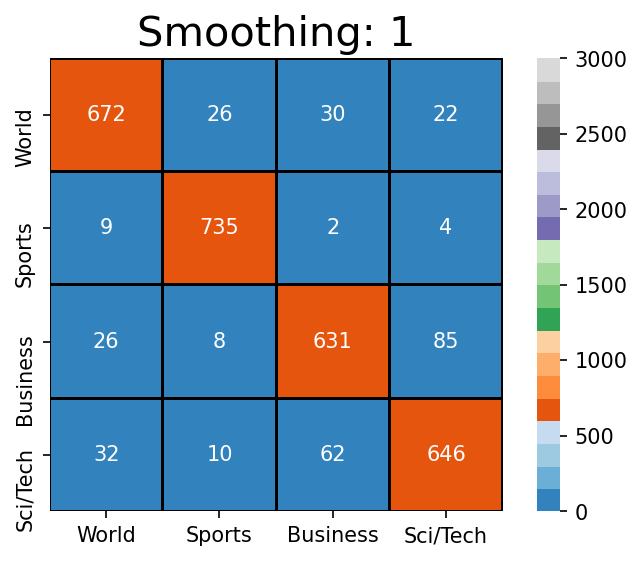

label precision recall
    1     0.909  0.896
    2     0.944  0.980
    3     0.870  0.841
    4     0.853  0.861
macro averaged precision: 0.8941419148538224
macro averaged recall: 0.8946666666666667
accuracy: 0.8946666666666667
macro averaged recall f1: 0.8944042137915661
+++++ Smoothing: 5 +++++


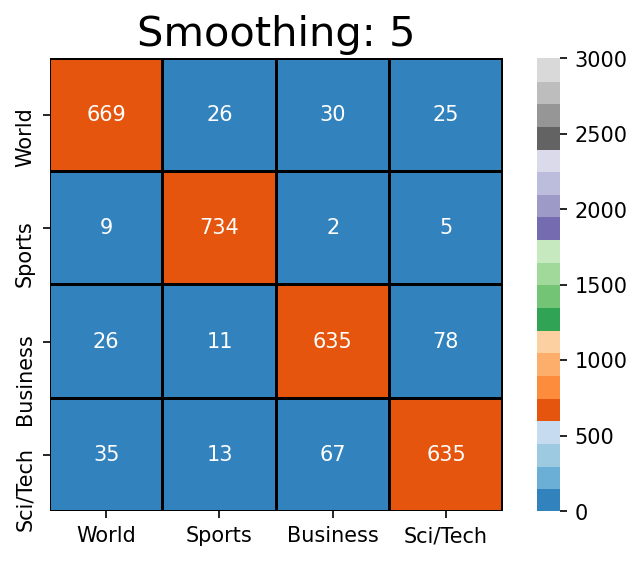

label precision recall
    1     0.905  0.892
    2     0.936  0.979
    3     0.865  0.847
    4     0.855  0.847
macro averaged precision: 0.8903169613284587
macro averaged recall: 0.891
accuracy: 0.891
macro averaged recall f1: 0.890658349710043
+++++ Smoothing: 25 +++++


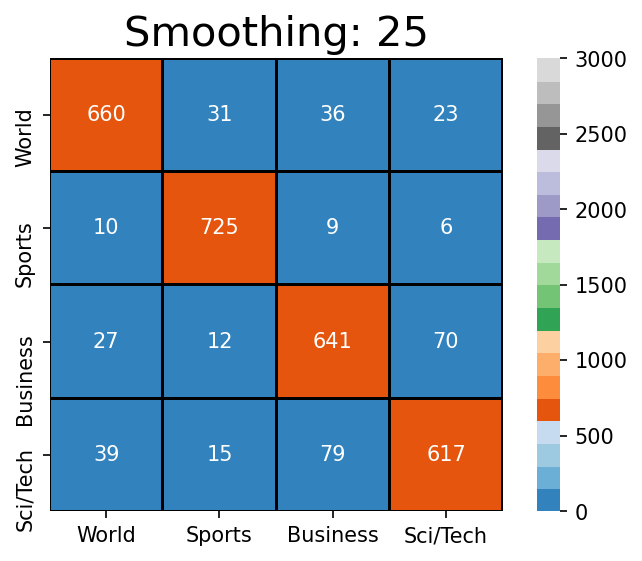

label precision recall
    1     0.897  0.880
    2     0.926  0.967
    3     0.838  0.855
    4     0.862  0.823
macro averaged precision: 0.8805763491670384
macro averaged recall: 0.881
accuracy: 0.881
macro averaged recall f1: 0.8807881236405021
+++++ Smoothing: 50 +++++


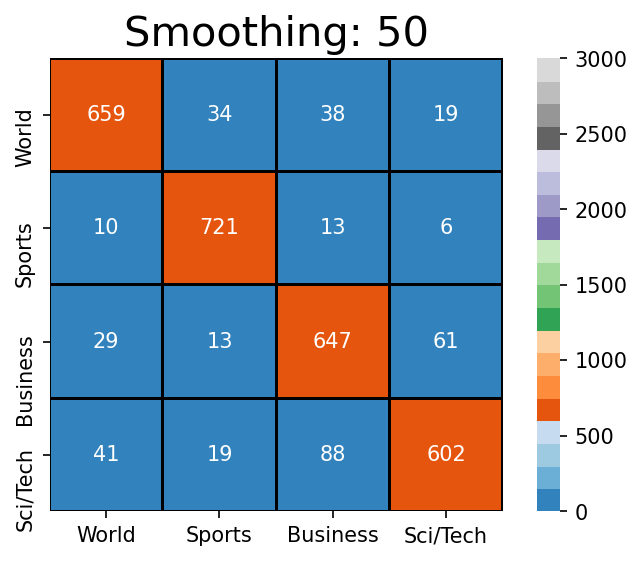

label precision recall
    1     0.892  0.879
    2     0.916  0.961
    3     0.823  0.863
    4     0.875  0.803
macro averaged precision: 0.8765095121093421
macro averaged recall: 0.8763333333333333
accuracy: 0.8763333333333333
macro averaged recall f1: 0.8764214138674461
+++++ Smoothing: 75 +++++


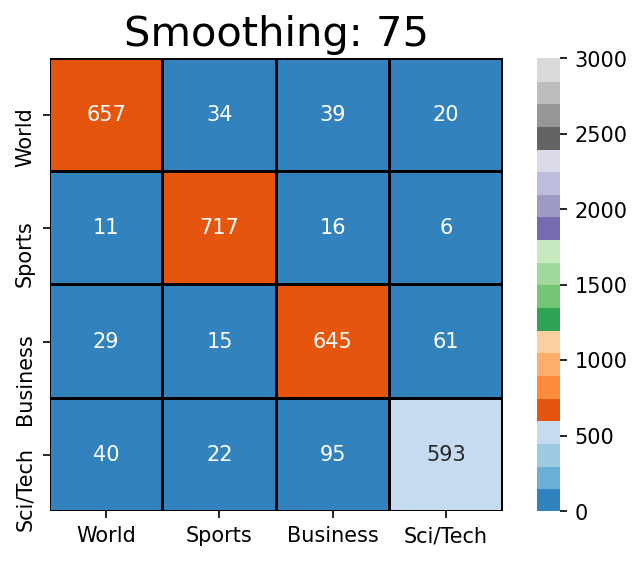

label precision recall
    1     0.891  0.876
    2     0.910  0.956
    3     0.811  0.860
    4     0.872  0.791
macro averaged precision: 0.8711824717885231
macro averaged recall: 0.8706666666666666
accuracy: 0.8706666666666667
macro averaged recall f1: 0.8709244928561922
+++++ Smoothing: 100 +++++


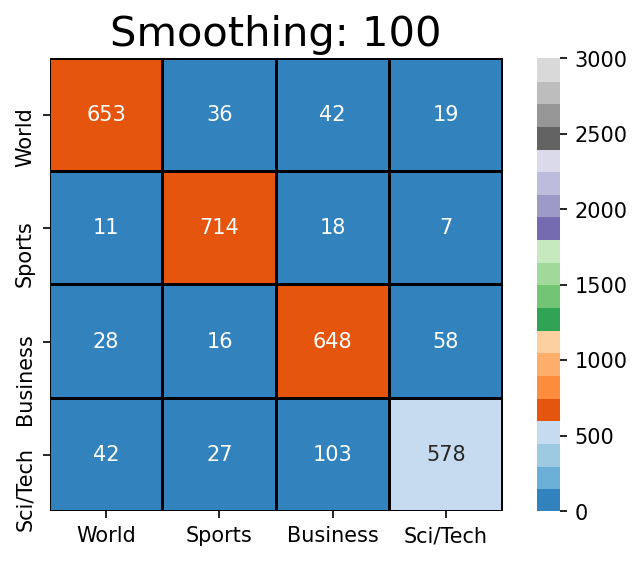

label precision recall
    1     0.890  0.871
    2     0.900  0.952
    3     0.799  0.864
    4     0.873  0.771
macro averaged precision: 0.865537358190081
macro averaged recall: 0.8643333333333333
accuracy: 0.8643333333333333
macro averaged recall f1: 0.864934926748927
+++++ Smoothing: 500 +++++


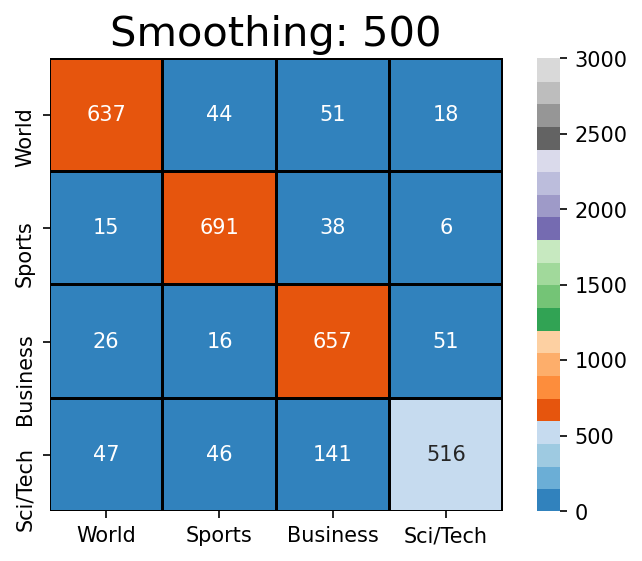

label precision recall
    1     0.879  0.849
    2     0.867  0.921
    3     0.741  0.876
    4     0.873  0.688
macro averaged precision: 0.83985434410117
macro averaged recall: 0.8336666666666666
accuracy: 0.8336666666666667
macro averaged recall f1: 0.8367490662230751
+++++ Smoothing: 1000 +++++


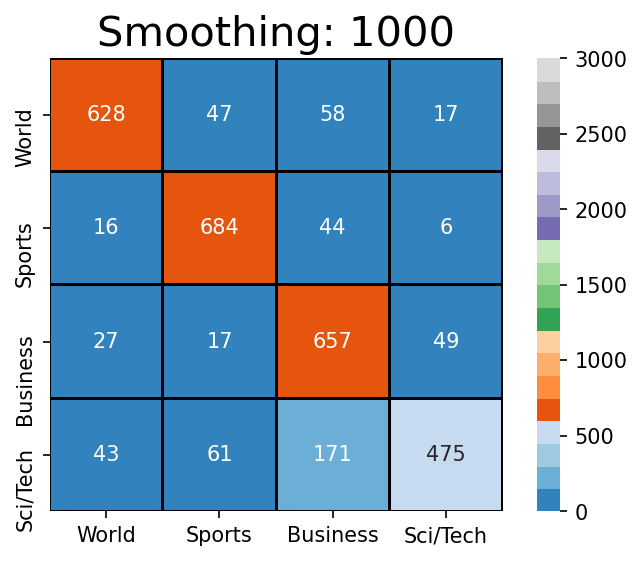

label precision recall
    1     0.880  0.837
    2     0.845  0.912
    3     0.706  0.876
    4     0.868  0.633
macro averaged precision: 0.8249661585165742
macro averaged recall: 0.8146666666666667
accuracy: 0.8146666666666667
macro averaged recall f1: 0.8197840640283516


In [15]:
test_naive_bayes(manager, val_documents, val_labels, smoothing_options, num_classes)

#### Conclusion 

The lower the smoothing value, the better the results!

## SVC 

In [16]:
from sklearn.svm import SVC

In [17]:
clf = SVC()

In [26]:
y_train = list(map(lambda doc: doc.category, manager.documents.values()))

In [ ]:
clf.fit(train_matrix, y_train)

/home/alireza/anaconda3/envs/skyrim/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## RandomForest 

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
clf = RandomForestClassifier(n_estimators=20, max_depth=50, random_state=seed)

In [25]:
clf.fit(train_matrix, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [26]:
predicted = clf.predict(val_matrix)

In [27]:
cm = MLMetrics.compute_confusion_matrix(val_labels, predicted)

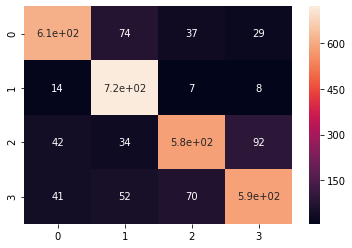

In [28]:
MLMetrics.plot_confusion_matrix(cm)

In [29]:
MLMetrics.print_summary_metrics(cm)

label precision recall
    1     0.863  0.813
    2     0.818  0.961
    3     0.836  0.776
    4     0.820  0.783
macro averaged precision: 0.8343070149474785
macro averaged recall: 0.8333333333333333
accuracy: 0.8333333333333334


## K-Means

In [60]:
import time

from src.ml import k_means

In [61]:
num_iterations = 1
num_centers = 4
initial_centroids = train_matrix[
    np.random.randint(0, num_train_docs, size=num_centers)
]

In [62]:
t1 = time.time()
x = kmeans(train_matrix, initial_centroids, num_centers, num_iterations)
t = time.time() - t1
print("SELFTIMED:", t)

SELFTIMED: 3.413062572479248


## TSNE

In [63]:
from sklearn.manifold import TSNE

In [71]:
chosen_documents = []

for index in range(num_train_docs):
    if index % 100 == 0:
        chosen_documents.append(train_matrix[index])

In [66]:
tsne = TSNE()

In [73]:
chosen_documents = np.array(chosen_documents)

In [74]:
chosen_documents.shape

(240, 26952)

In [76]:
X_embedded = tsne.fit_transform(chosen_documents)

In [77]:
X_embedded.shape

(240, 2)

In [78]:
import matplotlib.pyplot as plt

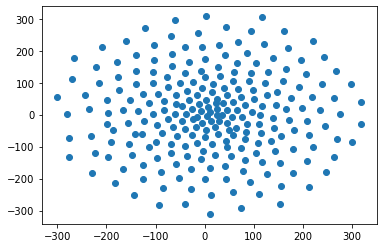

In [80]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])

## Word2Vec 

In [85]:
import gensim.models

In [81]:
class Dataloader:
    def __init__(self, documents: List[Document], fields: List[Fields]):
        self.documents = documents
        self.fields = fields

    def __iter__(self):
        for doc in self.documents:
            for field in self.fields:
                yield doc.get_tokens(field)

In [82]:
dataloader = Dataloader(train_documents, fields)

In [86]:
model = gensim.models.Word2Vec(sentences=dataloader)

In [87]:
model.wv["king"]

array([-0.3623317 ,  0.10780317, -0.58357865,  0.45032588,  0.69489473,
        0.24679019, -0.50850105,  0.12437668,  0.32068172, -0.12579438,
       -0.00772163,  0.49494675,  0.6378797 , -0.13193661, -0.09767683,
       -0.2422203 ,  0.38372147,  0.5191762 , -0.247552  , -0.36714154,
       -0.02394463,  0.4083664 ,  0.22410038,  0.11620622, -0.1426918 ,
        0.02337752, -0.13218105, -0.04538241,  0.3072743 , -0.32677984,
        0.6001206 ,  0.04847854, -0.11938937,  0.37793368, -0.24503504,
        0.14555036, -0.25179377, -0.4230027 , -0.35598025, -0.24799603,
        0.15657099,  0.04056478, -0.15975536,  0.09947734,  0.27979803,
        0.1847541 ,  0.0757205 ,  0.10864703, -0.16046683, -0.14812642,
       -0.1019834 , -0.2741378 ,  0.4162144 ,  0.32517296,  0.21145615,
        0.61283726, -0.16963753, -0.25392544, -0.20169456,  0.23046207,
       -0.5904062 , -0.19781153, -0.37859476, -0.0311013 ,  0.30228347,
       -0.3025139 ,  0.5745755 ,  0.06331573,  0.14278872,  0.14

In [91]:
model.wv.most_similar("rape")

[('fugit', 0.9774196743965149),
 ('tortur', 0.9744783639907837),
 ('pitcairn', 0.9734513759613037),
 ('convict', 0.972437858581543),
 ('activist', 0.9720022678375244),
 ('tamil', 0.9709989428520203),
 ('bashir', 0.9706947803497314),
 ('merci', 0.9703530669212341),
 ('sexual', 0.9697631597518921),
 ('serb', 0.9693998098373413)]

In [92]:
from sklearn.decomposition import IncrementalPCA  # inital reduction
from sklearn.manifold import TSNE  # final reduction
import numpy as np  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = []  # positions in vector space
    labels = []  # keep track of words to label our data again later
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))


try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly

ModuleNotFoundError: No module named 'plotly'

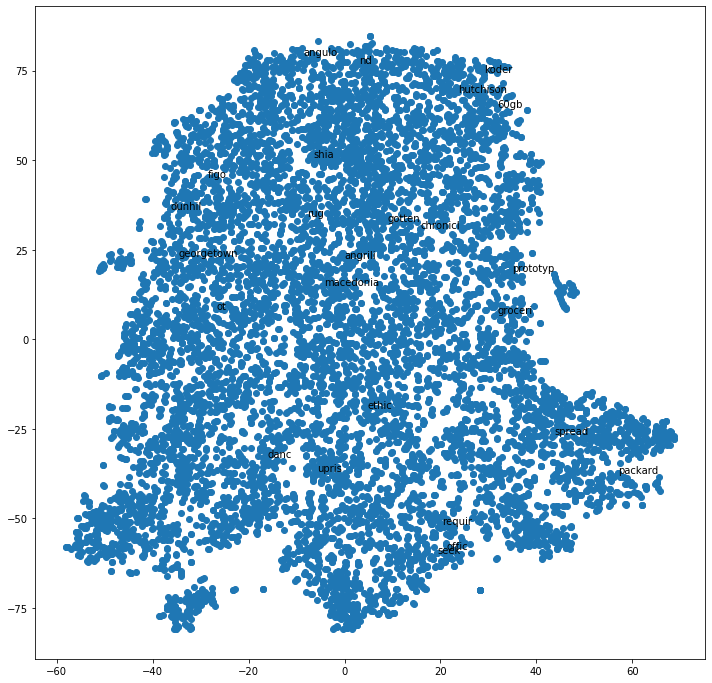

In [94]:
plot_with_matplotlib(x_vals, y_vals, labels)